(gaussian_process)=
# Gaussian Processes using numpy kernel

:::{post} 2016
:tags: gaussian processes, 
:category: advanced
:author: Chris Fonnesbeck
:::

Example of simple Gaussian Process fit, adapted from Stan's [example-models repository](https://github.com/stan-dev/example-models/blob/master/misc/gaussian-process/gp-fit.stan).

For illustrative and divulgative purposes, this example builds a Gaussian process from scratch. However, PyMC includes a {mod}`module dedicated to Gaussian Processes <pymc.gp>` which is recommended instead of coding everything from scratch.

In [1]:
import aesara.tensor as at
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import seaborn as sns

print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v4.1.3


In [2]:
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

In [3]:
# fmt: off
x = np.array([-5, -4.9, -4.8, -4.7, -4.6, -4.5, -4.4, -4.3, -4.2, -4.1, -4, 
-3.9, -3.8, -3.7, -3.6, -3.5, -3.4, -3.3, -3.2, -3.1, -3, -2.9, 
-2.8, -2.7, -2.6, -2.5, -2.4, -2.3, -2.2, -2.1, -2, -1.9, -1.8, 
-1.7, -1.6, -1.5, -1.4, -1.3, -1.2, -1.1, -1, -0.9, -0.8, -0.7, 
-0.6, -0.5, -0.4, -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5, 
0.6, 0.7, 0.8, 0.9, 1, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 
1.9, 2, 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3, 3.1, 
3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9, 4, 4.1, 4.2, 4.3, 4.4, 
4.5, 4.6, 4.7, 4.8, 4.9, 5])

y = np.array([1.04442478194401, 0.948306088493654, 0.357037759697332, 0.492336514646604, 
0.520651364364746, 0.112629866592809, 0.470995468454158, -0.168442254267804, 
0.0720344402575861, -0.188108980535916, -0.0160163306512027, 
-0.0388792158617705, -0.0600673630622568, 0.113568725264636, 
0.447160403837629, 0.664421188556779, -0.139510743820276, 0.458823971660986, 
0.141214654640904, -0.286957663528091, -0.466537724021695, -0.308185884317105, 
-1.57664872694079, -1.44463024170082, -1.51206214603847, -1.49393593601901, 
-2.02292464164487, -1.57047488853653, -1.22973445533419, -1.51502367058357, 
-1.41493587255224, -1.10140254663611, -0.591866485375275, -1.08781838696462, 
-0.800375653733931, -1.00764767602679, -0.0471028950122742, -0.536820626879737, 
-0.151688056391446, -0.176771681318393, -0.240094952335518, -1.16827876746502, 
-0.493597351974992, -0.831683011472805, -0.152347043914137, 0.0190364158178343, 
-1.09355955218051, -0.328157917911376, -0.585575679802941, -0.472837120425201, 
-0.503633622750049, -0.0124446353828312, -0.465529814250314, 
-0.101621725887347, -0.26988462590405, 0.398726664193302, 0.113805181040188, 
0.331353802465398, 0.383592361618461, 0.431647298655434, 0.580036473774238, 
0.830404669466897, 1.17919105883462, 0.871037583886711, 1.12290553424174, 
0.752564860804382, 0.76897960270623, 1.14738839410786, 0.773151715269892, 
0.700611498974798, 0.0412951045437818, 0.303526087747629, -0.139399513324585, 
-0.862987735433697, -1.23399179134008, -1.58924289116396, -1.35105117911049, 
-0.990144529089174, -1.91175364127672, -1.31836236129543, -1.65955735224704, 
-1.83516148300526, -2.03817062501248, -1.66764011409214, -0.552154350554687, 
-0.547807883952654, -0.905389222477036, -0.737156477425302, -0.40211249920415, 
0.129669958952991, 0.271142753510592, 0.176311762529962, 0.283580281859344, 
0.635808289696458, 1.69976647982837, 1.10748978734239, 0.365412229181044, 
0.788821368082444, 0.879731888124867, 1.02180766619069, 0.551526067300283])
# fmt: on
N = len(y)

We will use a squared exponential covariance function, which relies on the squared distances between observed points in the data.

In [4]:
squared_distance = lambda x, y: (x[None, :] - y[:, None]) ** 2

In [5]:
with pm.Model() as gp_fit:

    mu = np.zeros(N)

    eta_sq = pm.HalfCauchy("eta_sq", 5)
    rho_sq = pm.HalfCauchy("rho_sq", 5)
    sigma_sq = pm.HalfCauchy("sigma_sq", 5)

    D = squared_distance(x, x)

    # Squared exponential
    sigma = at.fill_diagonal(eta_sq * at.exp(-rho_sq * D), eta_sq + sigma_sq)

    obs = pm.MvNormal("obs", mu, sigma, observed=y)

This is what our initial covariance matrix looks like. Intuitively, every data point's Y-value correlates with points according to their squared distances.

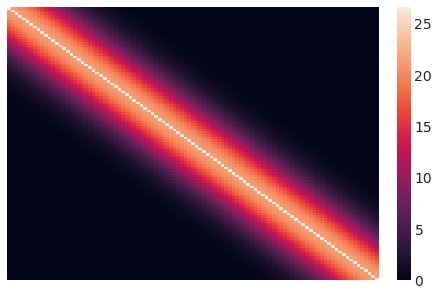

In [6]:
sns.heatmap(sigma.eval(), xticklabels=False, yticklabels=False);

The following generates predictions from the Gaussian Process model in a grid of values:

In [7]:
with gp_fit:

    # Prediction over grid
    xgrid = np.linspace(-6, 6)
    D_pred = squared_distance(xgrid, xgrid)
    D_off_diag = squared_distance(x, xgrid)

    # Covariance matrices for prediction
    sigma_pred = eta_sq * at.exp(-rho_sq * D_pred)
    sigma_off_diag = eta_sq * at.exp(-rho_sq * D_off_diag)

    # Posterior mean
    mu_post = pm.Deterministic(
        "mu_post", at.dot(at.dot(sigma_off_diag, pm.math.matrix_inverse(sigma)), y)
    )
    # Posterior covariance
    sigma_post = pm.Deterministic(
        "sigma_post",
        sigma_pred
        - at.dot(at.dot(sigma_off_diag, pm.math.matrix_inverse(sigma)), sigma_off_diag.T),
    )

In [8]:
with gp_fit:
    svgd_approx = pm.fit(400, method="svgd", inf_kwargs=dict(n_particles=100))

In [9]:
gp_trace = svgd_approx.sample(1000)

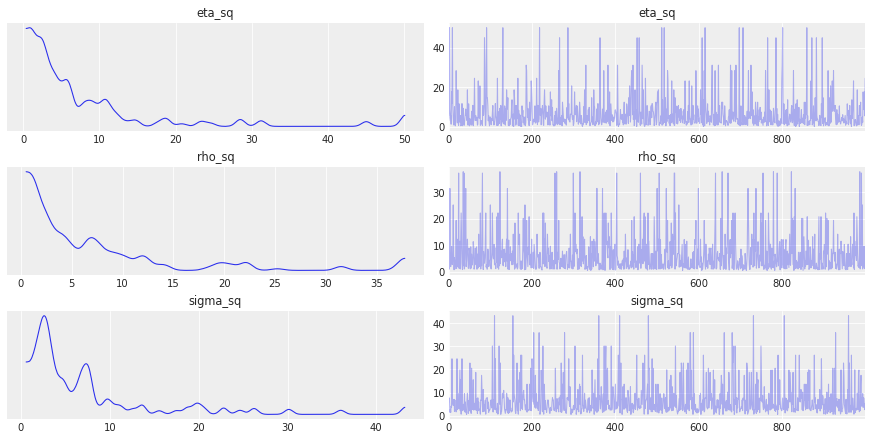

In [10]:
az.plot_trace(gp_trace, var_names=["eta_sq", "rho_sq", "sigma_sq"]);

Sample from the posterior Gaussian Process

In [11]:
multivariate = np.vectorize(np.random.multivariate_normal, signature="(n),(n, n)->(n)")
y_pred = multivariate(gp_trace.posterior["mu_post"][-1], gp_trace.posterior["sigma_post"][-1])

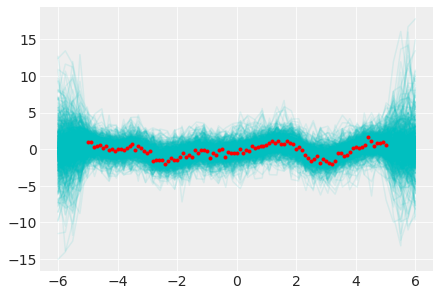

In [12]:
for yp in y_pred:
    plt.plot(np.linspace(-6, 6), yp, "c-", alpha=0.1)
plt.plot(x, y, "r.");

## Authors
*  Adapted from Stan's [example-models repository](https://github.com/stan-dev/example-models/blob/master/misc/gaussian-process/gp-fit.stan) by Chris Fonnesbeck in 2016
* Updated by Ana Rita Santos and Sandra Meneses in July, 2022 ([pymc#404](https://github.com/pymc-devs/pymc/pull/404))

In [13]:
%load_ext watermark
%watermark -n -u -v -iv -w -p aesara,aeppl,xarray

Last updated: Fri Jul 29 2022

Python implementation: CPython
Python version       : 3.10.5
IPython version      : 8.4.0

aesara: 2.7.7
aeppl : 0.0.32
xarray: 2022.3.0

sys       : 3.10.5 | packaged by conda-forge | (main, Jun 14 2022, 07:07:06) [Clang 13.0.1 ]
aesara    : 2.7.7
arviz     : 0.12.1
numpy     : 1.23.0
matplotlib: 3.5.2
pymc      : 4.1.3
seaborn   : 0.11.2

Watermark: 2.3.1



:::{include} ../page_footer.md
:::